# Multiclass Text Classification (SVM)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Multiclass Text Classification
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import svm
from sklearn.svm import LinearSVC

# Naive Bayes Classifiers (Bernoulli and Multinomial)
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

In [2]:
# Dask 
#import dask.dataframe as dd
#df = dd.read_csv('/Users/omaral-shammary/Downloads/complaints.csv')

In [3]:
p = 0.01 # 1% of sample
df = pd.read_csv('/Users/omaral-shammary/Downloads/complaints.csv', header=0,
                skiprows=lambda i: i>0 and random.random() > p)

In [4]:
len(df)

30831

# When our sample, n = 20000 vs n = 152317

In [5]:
# Randomally selected 1,000,000 samples to test our model
#df = df.sample(n=100000)
#len(df)

In [6]:
df.shape

(30831, 18)

In [7]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [8]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [9]:
df.columns=['Product', 'Consumer_complaint']

In [10]:
# Allows us to categorize the type of complaint that consumers have submitted
df['category_id'] = df['Product'].factorize()[0]

In [11]:
# Drops any duplicate complaints from the same person, and allows us to sort the value
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

In [12]:
category_to_id = dict(category_id_df.values)

In [13]:
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [14]:
df.head()

,Product,Consumer_complaint,category_id
25,"Credit reporting, credit repair services, or o...",I value your help to REMOVED a portion of the ...,0
84,"Credit reporting, credit repair services, or o...","XXXX XXXX, XXXX XXXX XXXX XXXX XXXXXXXX XXXX ...",0
103,"Credit reporting, credit repair services, or o...",Account closed and paid in full. \n\n\n\n\n\n\...,0
104,Checking or savings account,For years we had our accounts with USAA ( Unit...,1
111,"Credit reporting, credit repair services, or o...","On XX/XX/2022, I purchased a new AC unit for m...",0


<AxesSubplot:>

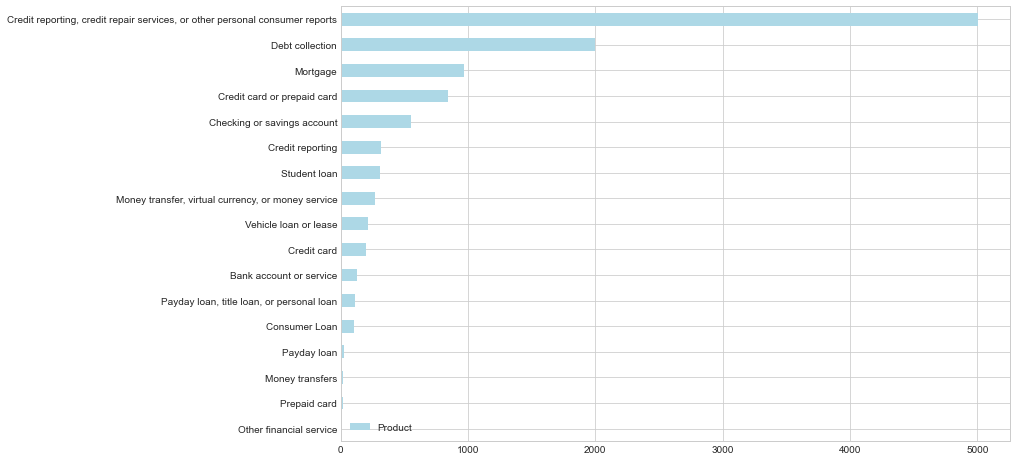

In [209]:
df.Product.value_counts(ascending=True).sort_values().to_frame().plot(kind='barh', figsize=(12,8), color= 'lightblue')

<Figure size 1080x576 with 0 Axes>

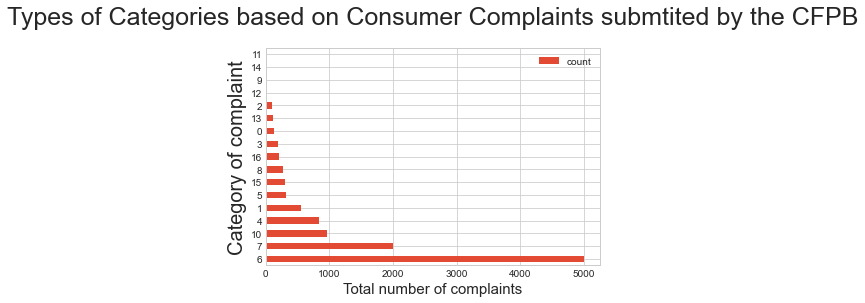

In [191]:
fig = plt.figure(figsize = (15,8))
df.groupby('Product').category_id.count().reset_index(name='count').sort_values((['count']), ascending=False).plot.barh(ylim=0, align='center');
plt.title('Types of Categories based on Consumer Complaints submtited by the CFPB', size=25, y=1.08)
plt.xlabel('Total number of complaints', size=15)
plt.ylabel('Category of complaint', size=20, x=1.25)
plt.style.use('seaborn-whitegrid')

plt.show()

# What we've learnt so far:

So:
- Use a subset of the dataframe, and compare accuracies for different subsets of the whole dataframe (25%, 60%, then whole dataframe of 3 million).
- Use PCA, KNN, other classification or ML methods to support model, and see which model is best.
- Look to see if you get the same results with PCA, does your method change the results that you got?

In [16]:
df['Product']

25       Credit reporting, credit repair services, or o...
84       Credit reporting, credit repair services, or o...
103      Credit reporting, credit repair services, or o...
104                            Checking or savings account
111      Credit reporting, credit repair services, or o...
                               ...                        
30809                                             Mortgage
30810                                        Consumer Loan
30811                                     Credit reporting
30812                                          Payday loan
30828                                      Debt collection
Name: Product, Length: 11078, dtype: object

# Support Vector Classifier (SVC) (A part of SVM)

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                       min_df = 5,
                       norm ='l2',
                       ngram_range = (1,2),
                       stop_words = 'english')

In [18]:
features = tfidf.fit_transform(df.Consumer_complaint).toarray()

In [19]:
labels = df.category_id
features.shape

(11078, 29768)

In [20]:
# X is Consumer Complaint, Y is our Product.
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint'],  df['Product'],
                                                   random_state=0, test_size=0.20, train_size=0.80)
# Count Vectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

# Tfidf Transformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [21]:
clf = LinearSVC().fit(X_train_tfidf, y_train)

In [22]:
X_train_tfidf.shape

(8862, 17733)

In [23]:
y_train.shape

(8862,)

In [24]:
print(clf.predict(count_vect.transform(['I have outdated information on my credit report'])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [25]:
y_pred = clf.predict(count_vect.transform(X_test))

In [26]:
print(metrics.classification_report(y_test,y_pred, labels=df['Product'], target_names=
                                   df['Product'].unique()))

/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2141: UserWarning: labels size, 11078, does not match size of target_names, 17
  warnings.warn(
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precisio

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.84      0.84      0.84       990
                                                 Checking or savings account       0.84      0.84      0.84       990
                                                 Credit card or prepaid card       0.84      0.84      0.84       990
                                                             Debt collection       0.53      0.79      0.63       107
                                   Payday loan, title loan, or personal loan       0.84      0.84      0.84       990
                                                                    Mortgage       0.53      0.79      0.63       107
                          Money transfer, virtual currency, or money service       0.53      0.79      0.63       107
                                                       

/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BernoulliNB (Naive Bayes Classifier)

In [27]:
clf2 = BernoulliNB().fit(X_train_tfidf, y_train)
print(clf2.predict(count_vect.transform(['I have outdated information on my credit report'])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [28]:
y_pred = clf2.predict(count_vect.transform(X_test))
print(metrics.classification_report(y_test,y_pred, labels=df['Product'], target_names=
                                   df['Product'].unique()))

/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2141: UserWarning: labels size, 11078, does not match size of target_names, 17
  warnings.warn(
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precisio

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.68      0.90      0.77       990
                                                 Checking or savings account       0.68      0.90      0.77       990
                                                 Credit card or prepaid card       0.68      0.90      0.77       990
                                                             Debt collection       0.50      0.33      0.40       107
                                   Payday loan, title loan, or personal loan       0.68      0.90      0.77       990
                                                                    Mortgage       0.50      0.33      0.40       107
                          Money transfer, virtual currency, or money service       0.50      0.33      0.40       107
                                                       

/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# MultinomialNB (Naive Bayes Classifier)

In [29]:
clf3 = MultinomialNB().fit(X_train_tfidf, y_train)
print(clf3.predict(count_vect.transform(['I have outdated information on my credit report'])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [30]:
y_pred = clf3.predict(count_vect.transform(X_test))

In [31]:
print(metrics.classification_report(y_test,y_pred, labels=df.Product, target_names=
                                   df['Product'].unique()))

/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:2141: UserWarning: labels size, 11078, does not match size of target_names, 17
  warnings.warn(
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precisio

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.45      1.00      0.62       990
                                                 Checking or savings account       0.45      1.00      0.62       990
                                                 Credit card or prepaid card       0.45      1.00      0.62       990
                                                             Debt collection       0.00      0.00      0.00       107
                                   Payday loan, title loan, or personal loan       0.45      1.00      0.62       990
                                                                    Mortgage       0.00      0.00      0.00       107
                          Money transfer, virtual currency, or money service       0.00      0.00      0.00       107
                                                       

/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVD / Singular Value Decomposition

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [172]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5, n_iter = 7, random_state=42)
clf4 = svd.fit_transform(X_train_tfidf,y_train)

In [173]:
print(svd.explained_variance_ratio_.sum())

0.1063197532264106


In [174]:
print(svd.explained_variance_ratio_)

[0.0176785  0.03942964 0.02097781 0.01463794 0.01359586]


In [34]:
print(svd.explained_variance_ratio_)

[0.0176785  0.03942964 0.02097781 0.01463794 0.01359586]


In [64]:
print(svd.explained_variance_ratio_.sum())

0.1063197532264106


In [65]:
print(svd.singular_values_)

[35.7638721  17.62535328 12.74166296 10.62761913 10.24189053]


# PCA

In [ ]:
# X is Consumer Complaint, Y is our Product.
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint'],  df['Product'],
                                                   random_state=0, test_size=0.20, train_size=0.80)
# Count Vectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

# Tfidf Transformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


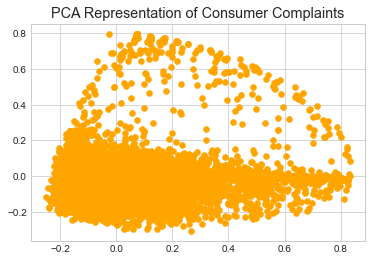

In [161]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])    

Xt = pipeline.fit_transform(X_train, y_train).todense()

pca = PCA(n_components=10).fit(Xt)
data2D = pca.transform(Xt)
plt.scatter(data2D[:,0], data2D[:,1], color = 'orange')
plt.title('PCA Representation of Consumer Complaints')
plt.style.use('seaborn-whitegrid')
plt.show()
#not required if using ipython n

# LSA 

In [162]:
svd = TruncatedSVD(n_components=5, n_iter = 7, random_state=42)
svd
#clf4 = svd.fit_transform(X_train_tfidf,y_train)

TruncatedSVD(n_components=5, n_iter=7, random_state=42)

/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


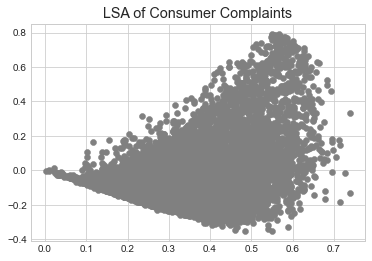

In [165]:
LSA = svd.fit_transform(Xt)
plt.title('LSA of Consumer Complaints')
plt.scatter(LSA[:,0], LSA[:,1], color = 'gray')
plt.show()

In [170]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10).fit(Xt)
centersdd = LSA.transform(kmeans.cluster_centers_)

#plt.hold(True)
plt.scatter(LSA[:,0], LSA[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.title('Indication of Differences between Specific Consumer Complaints') 
plt.style.use('seaborn-whitegrid')
plt.show()

/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


KeyboardInterrupt: 

In [156]:
X_train

25229    I spoked to an Agent Friday morning ( XX/XX/20...
13188    The following accounts were a result of fraud....
28519    XXXX is participating in deceptive practices I...
5134     This is an additional complaint to Bank of Ame...
1417     Unauthorized purchase of {$300.00} made via  X...
                               ...                        
12216    The account below was just readied to my credi...
8290     Went to The XXXX XXXX for a routine medical ap...
26890    On XXXX XXXX I had got a message on XXXX from ...
29930    These can be combined On my credit report, you...
7145     TransUnion LLC XXXX. XXXX XXXX XXXX, PA XXXX X...
Name: Consumer_complaint, Length: 8862, dtype: object

# KMeans

/Users/omaral-shammary/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


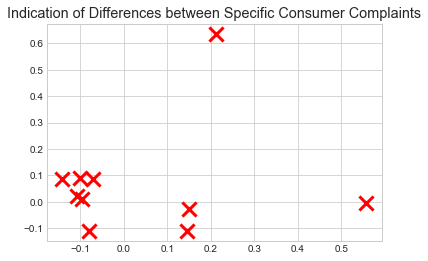

In [159]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10).fit(Xt)
centers2D = pca.transform(kmeans.cluster_centers_)

#plt.hold(True)
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.title('Indication of Differences between Specific Consumer Complaints')
plt.show()  
plt.style.use('seaborn-whitegrid')

# Create graph of top keywords that consumers have had issues with
# In this case, we see that there is a lot of misinformation/incorrect on reports
# Another is problems with credit reporting companies handinling an investigation of an existing problem.
# Attempts to collect debt not owed, improper use of report, and a lot more. 

In [44]:
# If we want to display our dataframes any further for analysis

#pd.set_option('display.max_rows', 100)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

In [45]:
# X features affect our output Y 
# So Consumer complaints are dependent on the product/company

In [46]:
# Y represents consumer complaint
# X represents the product

### Naive Bayes vs. SVM for classifying text data

The biggest difference between the models you're building from a "features" point of view is that Naive Bayes treats them as independent, whereas SVM looks at the interactions between them to a certain degree, as long as you're using a non-linear kernel (Gaussian, rbf, poly etc.). So if you have interactions, and, given your problem, you most likely do, an SVM will be better at capturing those, hence better at the classification task you want.

The consensus for ML researchers and practitioners is that in almost all cases, the SVM is better than the Naive Bayes.

From a theoretical point of view, it is a little bit hard to compare the two methods. One is probabilistic in nature, while the second one is geometric. However, it's quite easy to come up with a function where one has dependencies between variables which are not captured by Naive Bayes (y(a,b) = ab), so we know it isn't an universal approximator. SVMs with the proper choice of Kernel are (as are 2/3 layer neural networks) though, so from that point of view, the theory matches the practice.

But in the end it comes down to performance on your problem - you basically want to choose the simplest method which will give good enough results for your problem and have a good enough performance. Spam detection has been famously solvable by just Naive Bayes, for example. Face recognition in images by a similar method enhanced with boosting etc.

Support Vector Machine (SVM) is better at full-length content.
Multinomial Naive Bayes (MNB) is better at snippets.
MNB is stronger for snippets than for longer documents. While (Ng and Jordan, 2002) showed that NB is better than SVM/logistic regression (LR) with few training cases, MNB is also better with short documents. SVM usually beats NB when it has more than 30–50 training cases, we show that MNB is still better on snippets even with relatively large training sets (9k cases).

Inshort, NBSVM seems to be an appropriate and very strong baseline for sophisticated classification text data.

http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf

Cite: Wang, Sida, and Christopher D. Manning. "Baselines and bigrams: Simple, good sentiment and topic classification." Proceedings of the 50th Annual Meeting of the Association for Computational Linguistics: Short Papers-Volume 2. Association for Computational Linguistics, 2012.